In [212]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Importing standard Qiskit libraries
from qiskit.utils import algorithm_globals
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
# from ibm_quantum_widgets import *
from qiskit import BasicAer
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap

from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import PegasosQSVC

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
# service = QiskitRuntimeService(channel="ibm_quantum")

algorithm_globals.random_seed = 12345


In [213]:
df = pd.read_csv('card_transdata.csv')
# Drop rows with NaN values
df = df.dropna()

df = df.rename(columns={'fraud': 'class'})
df = df.rename(columns={'distance_from_home': '1'})
df = df.rename(columns={'distance_from_last_transaction': '2'})
df = df.rename(columns={'ratio_to_median_purchase_price': '3'})
df = df.rename(columns={'repeat_retailer': '4'})
df = df.rename(columns={'used_chip': '5'})
df = df.rename(columns={'used_pin_number': '6'})
df = df.rename(columns={'online_order': '7'})

# Select the first three columns
cols_to_normalize = ['1', '2', '3']

In [214]:
# split out unseen test set
train_df, test_df = train_test_split(
    df,
    test_size=1000,
    random_state=algorithm_globals.random_seed,
    stratify=df.iloc[:,-1]
    )

# split out validation set
train_df, val_df = train_test_split(
    train_df,
    test_size=1000,
    random_state=algorithm_globals.random_seed,
    stratify=train_df.iloc[:,-1]
    )

#shuffle and reset index in-place of test
test_df = test_df.sample(frac=1).reset_index(drop=True)

test_features = test_df.iloc[:, :-1]
test_labels = test_df.iloc[:, -1]

#shuffle and reset index in-place of val
val_df = val_df.sample(frac=1).reset_index(drop=True)

val_features = val_df.iloc[:, :-1]
val_labels = val_df.iloc[:, -1]

In [215]:
# get out the equally balanced fraud and non fraud cases
nonfraud_df = train_df[train_df['class'] == 0.0].sample(n=1000, ignore_index=True, random_state=42)
fraud_df = train_df[train_df['class'] == 1.0].sample(n=1000, ignore_index=True, random_state=42)

train_df = pd.concat([fraud_df, nonfraud_df])

#shuffle and reset index in-place
train_df = train_df.sample(frac=1).reset_index(drop=True)



In [216]:
train_df.head()

,1,2,3,4,5,6,7,class
0,3.622364,2.169757,1.101860,1.0,0.0,0.0,0.0,0.0
1,1.450421,0.062994,4.460905,0.0,0.0,0.0,0.0,1.0
2,64.882148,0.135197,1.588111,1.0,1.0,0.0,1.0,0.0
3,236.335370,3.572224,0.568215,1.0,0.0,0.0,1.0,1.0
4,274.900924,1.781220,0.626003,1.0,0.0,0.0,1.0,1.0


In [217]:
# Create the MinMaxScaler object
scaler = MinMaxScaler()

train_features = train_df.iloc[:, :-1]
train_labels = train_df.iloc[:, -1]

scaler = MinMaxScaler(feature_range=(0, np.pi))
train_features = scaler.fit_transform(train_features)
val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

In [218]:
train_df['class'].value_counts()

class
0.0    1000
1.0    1000
Name: count, dtype: int64

In [219]:
num_samples = 2000
train_size = 0.8

# # DIY removal of data
# features, removed_features, labels, removed_labels = train_test_split(
#     features, labels, train_size=num_samples, shuffle=False
# )

# split more to have less data
# train_features, test_features, train_labels, test_labels = train_test_split(
#     features, labels, train_size=train_size, shuffle=False
# )

In [220]:
# number of qubits is equal to the number of features
num_qubits = 7

# number of steps performed during the training procedure
tau = 300

# regularization parameter
C = 100

     ┌───────────────────────────────────────────────────┐
q_0: ┤0                                                  ├
     │                                                   │
q_1: ┤1                                                  ├
     │                                                   │
q_2: ┤2                                                  ├
     │                                                   │
q_3: ┤3 ZZFeatureMap(x[0],x[1],x[2],x[3],x[4],x[5],x[6]) ├
     │                                                   │
q_4: ┤4                                                  ├
     │                                                   │
q_5: ┤5                                                  ├
     │                                                   │
q_6: ┤6                                                  ├
     └───────────────────────────────────────────────────┘


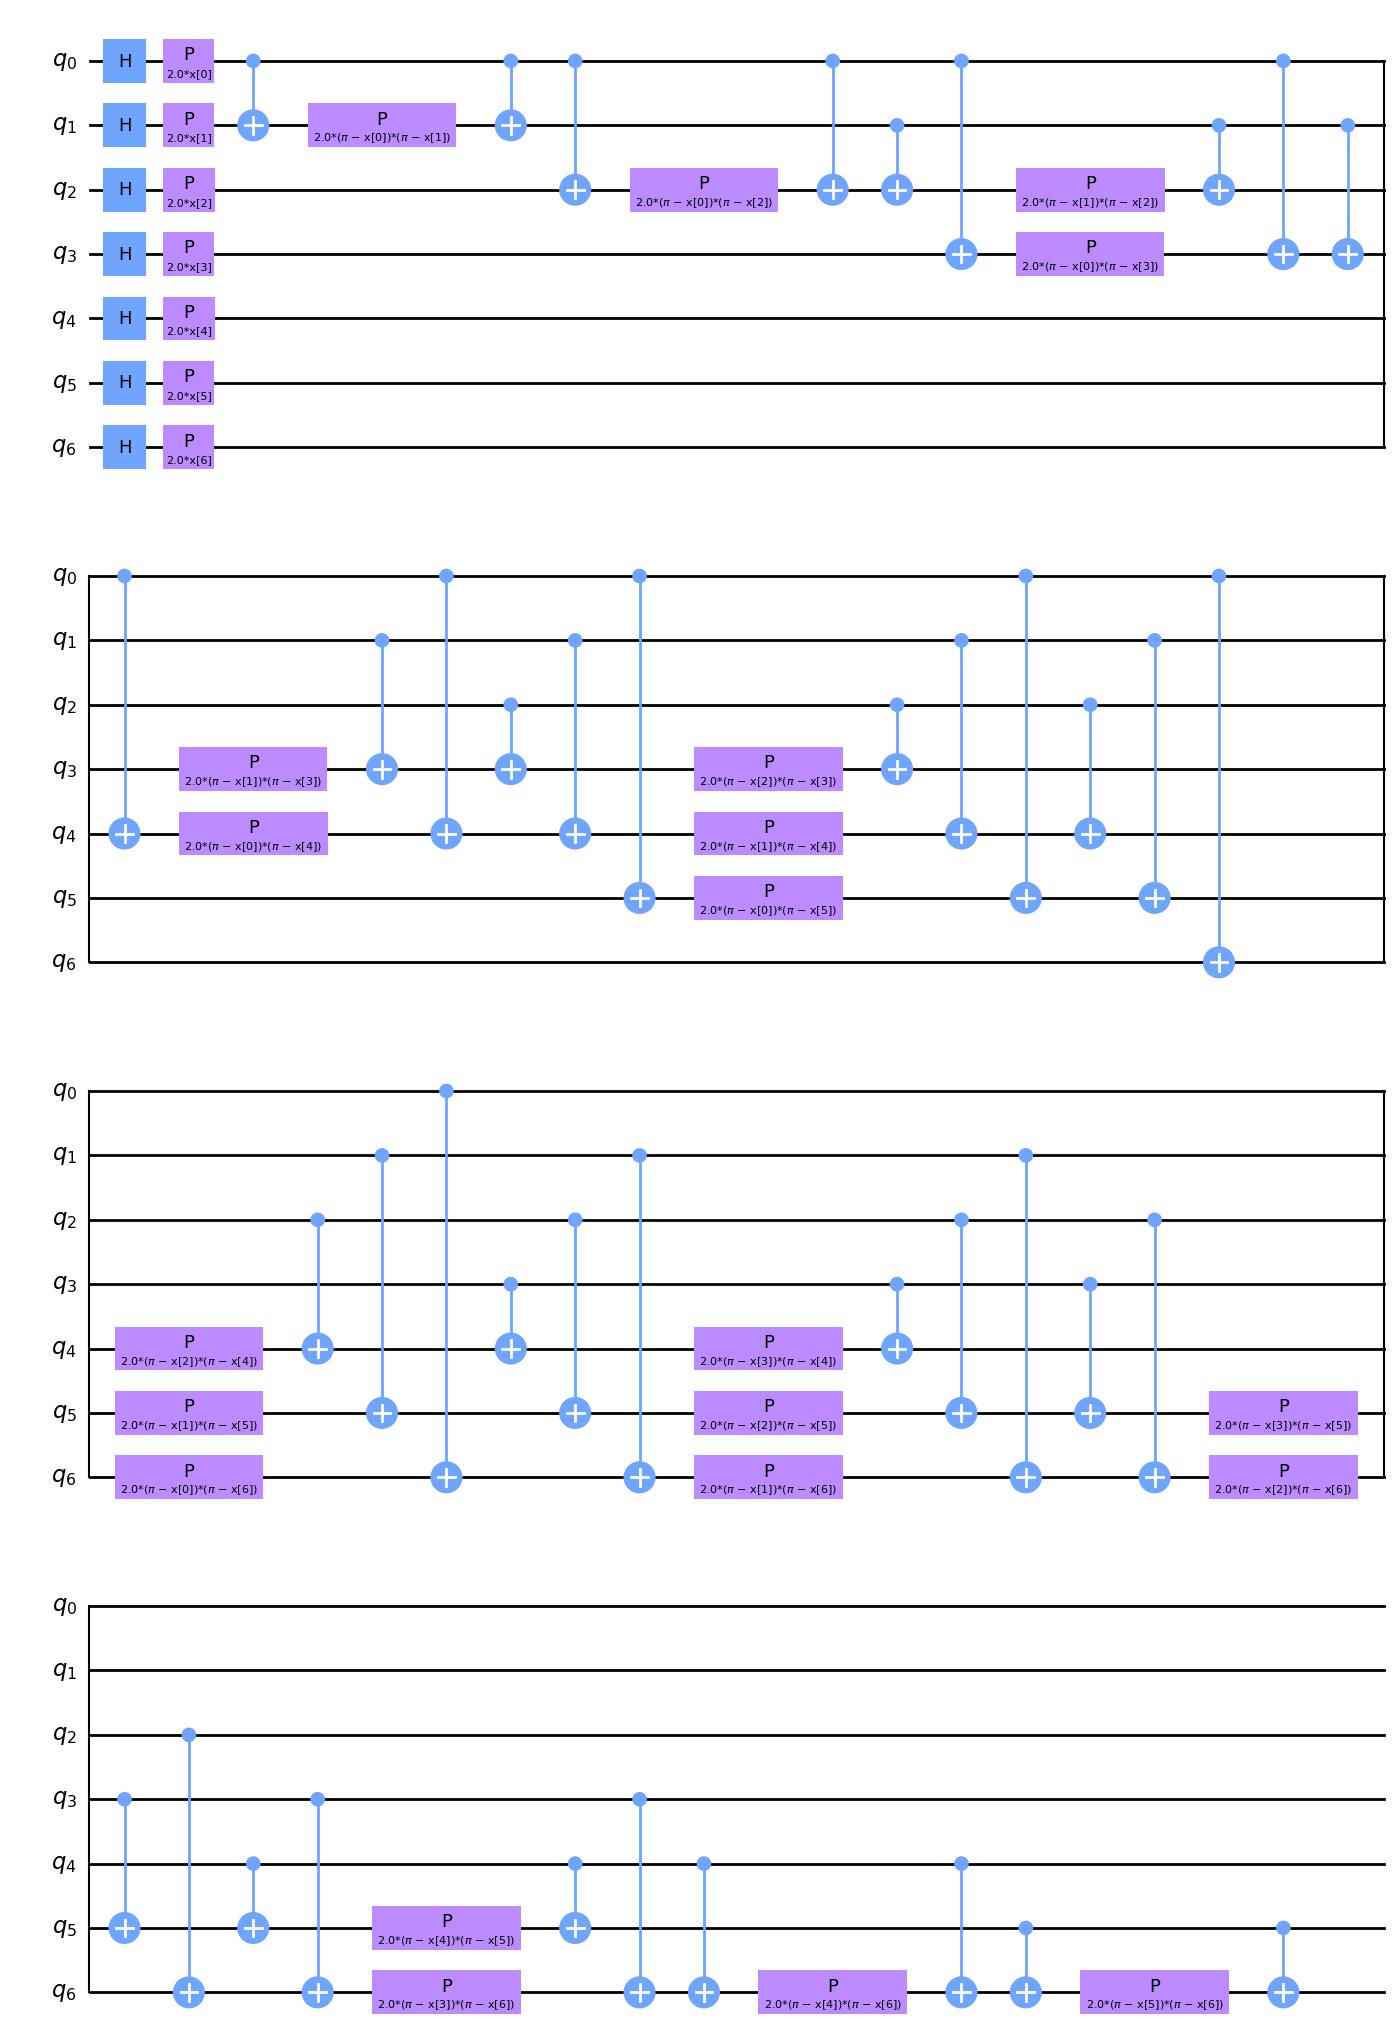

In [221]:
feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=1)
print(feature_map)

qkernel = FidelityQuantumKernel(feature_map=feature_map)
feature_map.decompose().draw(output="mpl", fold=20)

In [222]:
print(len(train_labels))

2000


In [223]:
print(type(train_features))
print(type(val_features))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [224]:
test_labels.value_counts()

class
0.0    913
1.0     87
Name: count, dtype: int64

In [225]:
# import time
# from sklearn.metrics import classification_report, fbeta_score

# possible_C = [0.00001, 0.001, 1, 100]
# possible_tau = [10, 25, 50, 100, 200, 300]

# #for testing purposes
# # possible_C = [0.00001]
# # possible_tau = [1, 2]

# best_C = 0
# best_tau = 0
# best_fbeta = 0

# txtname = 'pegasos_ZFeatureMap_balanced_2000_0706_reps3.txt'

# f = open(f"{txtname}", 'w')
# f.close()

# for C in possible_C:
#     for tau in possible_tau:
#         f = open(f"{txtname}", 'a')
            
#         print(f"\nC used is {C}, tau used is {tau}")
        
#         pegasos_qsvc = PegasosQSVC(quantum_kernel=qkernel, C=C, num_steps=tau)
        
#         f.write(f"\nC used is {C}, tau used is {tau}\n")

#         # training
#         print('TRAINING')
#         start_train = time.time()
#         pegasos_qsvc.fit(train_features, train_labels)
#         elapsed_train = time.time() - start_train
#         f.write(f"Training time: {round(elapsed_train)} seconds\n")

#         # testing
#         print('TESTING on validation set')
#         start_val = time.time()
#         pred_labels = pegasos_qsvc.predict(val_features)
#         confusionmatrix = str(confusion_matrix(val_labels, pred_labels))
#         f.write(confusionmatrix)
#         f.write('\n-----------\n')
#         class_report = str(classification_report(val_labels, pred_labels))
#         f.write(class_report)
#         fbeta = fbeta_score(val_labels, pred_labels, average='binary', beta=2)

#         if fbeta > best_fbeta:
#             best_fbeta = fbeta
#             best_C = C
#             best_tau = tau

#         f.write(f'F2 score:{fbeta}\n')
#         elapsed_val = time.time() - start_val
#         f.write(f"Validation time: {round(elapsed_val)} seconds\n")
#         f.write('-' * 50)
#         f.close()

# f = open(f"{txtname}", 'a')
# f.write(f"\n\nThe best parameters found based on F2-score is C={best_C}, and tau={best_tau}. Highest F2-score of {best_fbeta}")        
# f.close()

# print(f"\nThe best parameters found based on F2-score is C={best_C}, and tau={best_tau}. Highest F2-score of {best_fbeta}")

In [227]:
pegasos_qsvc = PegasosQSVC(quantum_kernel=qkernel, C=C, num_steps=tau)

# # training
pegasos_qsvc.fit(train_features, train_labels)

import time
start_test = time.time()
pred_labels = pegasos_qsvc.predict(test_features)
confusionmatrix = str(confusion_matrix(test_labels, pred_labels))
print(confusionmatrix)
class_report = str(classification_report(test_labels, pred_labels))
print(class_report)

print(time.time() - start_test)

[[823  90]
 [  0  87]]
              precision    recall  f1-score   support

         0.0       1.00      0.90      0.95       913
         1.0       0.49      1.00      0.66        87

    accuracy                           0.91      1000
   macro avg       0.75      0.95      0.80      1000
weighted avg       0.96      0.91      0.92      1000

776.1117608547211


In [ ]:
# # testing

# best_hyperparams = {
#     'reps': [1, 2, 3],
#     'C': [100, 0.001, 100],
#     'tau': [300, 100, 300],
# }

# zfeaturemap = []

# print("FINAL TESTING SET")

# for i in range(3):

#     print(f"Results for reps = {i+1}")

#     feature_map = ZFeatureMap(feature_dimension=num_qubits, reps=best_hyperparams['reps'][i])
#     qkernel = FidelityQuantumKernel(feature_map=feature_map)

#     pegasos_qsvc = PegasosQSVC(
#         quantum_kernel=qkernel,
#         C=best_hyperparams['C'][i],
#         num_steps=best_hyperparams['tau'][i]
#         )

#     pegasos_qsvc.fit(train_features, train_labels)

#     val_pred_labels = pegasos_qsvc.predict(val_features)
#     print(confusion_matrix(val_labels, val_pred_labels))
#     print(classification_report(val_labels, val_pred_labels))
#     val_f2 = fbeta_score(val_labels, val_pred_labels, average='binary', beta=2)
#     print(f"F2 score: {val_f2}")

#     test_pred_labels = pegasos_qsvc.predict(test_features)
#     print(confusion_matrix(test_labels, test_pred_labels))
#     print(classification_report(test_labels, test_pred_labels))
#     test_f2 = fbeta_score(test_labels, test_pred_labels, average='binary', beta=2)
#     print(f"F2 score: {test_f2}")

#     zfeaturemap.append((val_f2, test_f2))

FINAL TESTING SET
Results for reps = 1
[[876  37]
 [ 38  49]]
              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96       913
         1.0       0.57      0.56      0.57        87

    accuracy                           0.93      1000
   macro avg       0.76      0.76      0.76      1000
weighted avg       0.92      0.93      0.92      1000

F2 score: 0.5645161290322581
[[870  43]
 [ 36  51]]
              precision    recall  f1-score   support

         0.0       0.96      0.95      0.96       913
         1.0       0.54      0.59      0.56        87

    accuracy                           0.92      1000
   macro avg       0.75      0.77      0.76      1000
weighted avg       0.92      0.92      0.92      1000

F2 score: 0.5769230769230768
Results for reps = 2
[[897  16]
 [ 71  16]]
              precision    recall  f1-score   support

         0.0       0.93      0.98      0.95       913
         1.0       0.50      0.18      0.27       

In [ ]:
# # testing

# best_hyperparams = {
#     'reps': [1, 2, 3],
#     'C': [100, 100, 1],
#     'tau': [300, 200, 50],
# }

# zzfeaturemap = []

# print("FINAL TESTING SET")

# for i in range(3):

#     print(f"Results for reps = {i+1}")

#     feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=best_hyperparams['reps'][i])
#     qkernel = FidelityQuantumKernel(feature_map=feature_map)

#     pegasos_qsvc = PegasosQSVC(
#         quantum_kernel=qkernel,
#         C=best_hyperparams['C'][i],
#         num_steps=best_hyperparams['tau'][i]
#         )

#     pegasos_qsvc.fit(train_features, train_labels)

#     val_pred_labels = pegasos_qsvc.predict(val_features)
#     print(confusion_matrix(val_labels, val_pred_labels))
#     print(classification_report(val_labels, val_pred_labels, zero_division=0))
#     val_f2 = fbeta_score(val_labels, val_pred_labels, average='binary', beta=2)
#     print(f"F2 score: {val_f2}")

#     test_pred_labels = pegasos_qsvc.predict(test_features)
#     print(confusion_matrix(test_labels, test_pred_labels))
#     print(classification_report(test_labels, test_pred_labels, zero_division=0))
#     test_f2 = fbeta_score(test_labels, test_pred_labels, average='binary', beta=2)
#     print(f"F2 score: {test_f2}")

#     zzfeaturemap.append((val_f2, test_f2))

FINAL TESTING SET
Results for reps = 1
[[782 131]
 [  0  87]]
              precision    recall  f1-score   support

         0.0       1.00      0.86      0.92       913
         1.0       0.40      1.00      0.57        87

    accuracy                           0.87      1000
   macro avg       0.70      0.93      0.75      1000
weighted avg       0.95      0.87      0.89      1000

F2 score: 0.7685512367491166
[[784 129]
 [  0  87]]
              precision    recall  f1-score   support

         0.0       1.00      0.86      0.92       913
         1.0       0.40      1.00      0.57        87

    accuracy                           0.87      1000
   macro avg       0.70      0.93      0.75      1000
weighted avg       0.95      0.87      0.89      1000

F2 score: 0.7712765957446808
Results for reps = 2
[[818  95]
 [  3  84]]
              precision    recall  f1-score   support

         0.0       1.00      0.90      0.94       913
         1.0       0.47      0.97      0.63       

In [ ]:
# print(zfeaturemap)

# print(zzfeaturemap)

[(0.5645161290322581, 0.5769230769230768), (0.2105263157894737, 0.31007751937984496), (0.6796875000000001, 0.6957928802588996)]


NameError: name 'zzfeaturemap' is not defined